NVT

<ipython-input-4-15bd3c3f4f58>:103: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta_U):


Iteration: 0, Energy: 43073635833037.80, Delta U: -1617.82
Iteration: 1000, Energy: 13835728868080.18, Delta U: 472.17
Iteration: 2000, Energy: 2780898971.96, Delta U: 15.25
Iteration: 3000, Energy: 125182757.03, Delta U: -6.59
Iteration: 4000, Energy: 85578404.57, Delta U: -511.17
Iteration: 5000, Energy: 83041858.98, Delta U: 20.00
Iteration: 6000, Energy: 260842.66, Delta U: 30.43
Iteration: 7000, Energy: 192794.04, Delta U: 23.31
Iteration: 8000, Energy: 54180.76, Delta U: -5.48
Iteration: 9000, Energy: 40335.25, Delta U: 29.89
Iteration: 10000, Energy: 16335.09, Delta U: 20.09
Iteration: 11000, Energy: 8860.23, Delta U: 62.27
Iteration: 12000, Energy: 6336.25, Delta U: 93.14
Iteration: 13000, Energy: 3672.08, Delta U: 188.07
Iteration: 14000, Energy: 2375.95, Delta U: 1.64
Iteration: 15000, Energy: 1023.25, Delta U: 1.12
Iteration: 16000, Energy: 276.72, Delta U: 0.55
Iteration: 17000, Energy: -159.35, Delta U: 18.36
Iteration: 18000, Energy: -612.48, Delta U: 2.97
Iteration: 1900

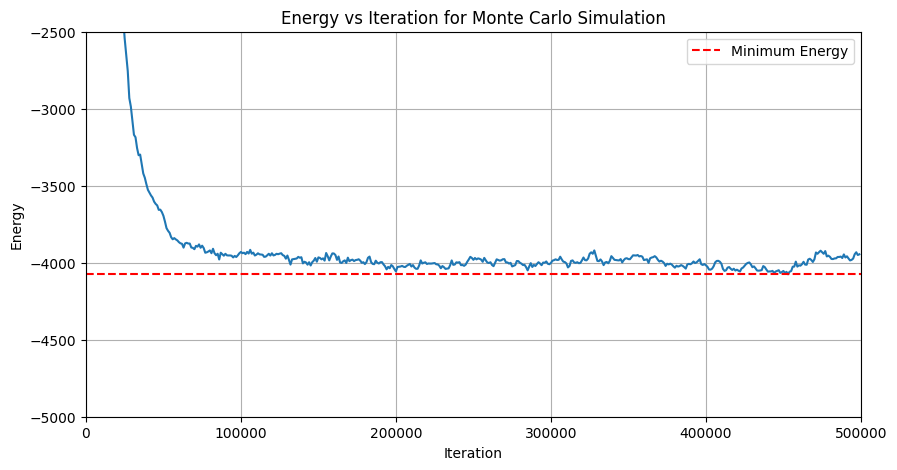

Final energy: -3969.86
Minimum energy pr particle -4.075


In [ ]:
# Energy plot - Liquid
import numpy as np
import matplotlib.pyplot as plt
# Parameters
N = 1000  # Number of particles
rho = 0.74  # Density liq  = 0.74, Density gas = 0.026
L = (N / rho)**(1/3)  # Length of the cubic box
epsilon = 1.05  # Energy scale based on the condition
sigma = 1.0  # Distance scale
kB = 1.0  # Boltzmann constant
T = 1  # Temperature
num_iterations = 500000  # Can be adjusted with our need
delta = 0.5  # Maximum displacement for Monte Carlo move Liquid

# Initialize particle positions randomly - CHANGED COORDINATESYSTEM to
np.random.seed(0)  # For reproducibility
x = (np.random.rand(N)-0.5) * L # array of N random numbers from -1L to 1L
y = (np.random.rand(N)-0.5) * L
z = (np.random.rand(N)-0.5) * L
print
# Periodic boundary conditions (PBC). If a particle crosses the boundary, it re-enters from the opposite side.
def apply_pbc(dx, dy, dz, L):
    dx = dx - np.round(dx / L) * L
    dy = dy - np.round(dy / L) * L
    dz = dz - np.round(dz / L) * L
    return dx, dy, dz
#Calculate the total potential energy of the system
def U_full_slicing(x, y, z, L):
    result = 0.0
    for d in range(len(x) - 1):
        dx = x[d] - x[d+1:]
        dy = y[d] - y[d+1:]
        dz = z[d] - z[d+1:]
        # Apply periodic boundary conditions (PBC)
        dx, dy, dz = apply_pbc(dx, dy, dz, L)
        # Lennard-Jones potential is used to calculate the interaction energy between particles
        r2 = dx**2 + dy**2 + dz**2
        phi = 4 * epsilon * ((sigma**12 / r2**6) - (sigma**6 / r2**3))
        phi[r2 >= 2.5] = 0  # Safety threshold to ignore large distances
        result += np.sum(phi)
    return result
# Calculating Energy for One Particle, used to compute the energy difference when a particle is moved.
def U_for_one_particle(x, y, z, L, identity):
    # Calculate displacements between particle `identity` and all others
    dx = (x[identity] - x[np.arange(len(x)) != identity])
    dy = (y[identity] - y[np.arange(len(y)) != identity])
    dz = (z[identity] - z[np.arange(len(z)) != identity])

    # Apply PBC
    dx, dy, dz = apply_pbc(dx, dy, dz, L)

    # Calculate distances
    r2 = dx**2 + dy**2 + dz**2
    phi = np.zeros_like(r2)

    # Mask for valid distances under cutoff
    new_mask = r2 < 2.5
    if np.any(r2[new_mask] == 0):
        print("Warning: very close particles detected!")

    # Calculate Lennard-Jones potential
    phi[new_mask] = 4 * 1.05 * ((sigma**12 / r2[new_mask]**6) - (sigma**6 / r2[new_mask]**3))
    return np.sum(phi[new_mask])


# Main simulation loop
U_initial = U_full_slicing(x, y, z, L)
U_last = U_initial

# List to store energy values for plotting
energy_values = []
energy_list = []
energy_array = np.array(energy_list)
energy_interval = 1000  # How often to store energy( just to check)

# Initialize particle position arrays to store coordinates during sampling
sampled_coordinates_liq = []
#coord_for_average = []

# Define the number of sampling runs you want after equilibrium
num_samples = 10  # Sample 10000 runs after equilibrium

for iteration in range(num_iterations):
    # Choose a random particle
    identity = np.random.randint(N)
    U_oldp = U_for_one_particle(x, y, z, L, identity)
    # Save the current position
    old_x, old_y, old_z = x[identity], y[identity], z[identity]

    # Propose a new position
    x[identity] += (np.random.rand() - 0.5) * delta
    y[identity] += (np.random.rand() - 0.5) * delta
    z[identity] += (np.random.rand() - 0.5) * delta

    # Apply periodic boundary conditions (PBC)
    x[identity], y[identity], z[identity] = apply_pbc(x[identity], y[identity], z[identity], L)

    # Calculate the energy change
    U_newp = U_for_one_particle(x, y, z, L, identity) # Edited!
    delta_U = U_newp - U_oldp

    # Metropolis acceptance criterion
    if np.random.rand() < np.exp(-delta_U):
        # Accept the move
        U_last += delta_U
    else:
        # Reject the move and revert to the old position
        x[identity], y[identity], z[identity] = old_x, old_y, old_z

    # Updating energy by calculation 10% of the time
    if iteration%(num_iterations/10) == 0:
          U_last = U_full_slicing(x, y, z, L)

    energy_array = np.append(energy_array, U_last) # Appending the previous U to energy array, regardless of acceptance/rejection
    # Calculate and store energy every 1000 iterations
    if iteration % 1000 == 0:
        print(f"Iteration: {iteration}, Energy: {U_last:.2f}, Delta U: {delta_U:.2f}")
 # Store energy every energy_interval iterations
    if iteration % energy_interval == 0:
        energy_values.append(U_last)
    if iteration >= (9*num_iterations/10) and iteration % 100000 == 0 and len(sampled_coordinates_liq) < num_samples:
        # Store current coordinates of all particles
      sampled_coordinates_liq.append(np.vstack((x, y, z)).T)  # Store x, y, z coordinates for all particles
    """
    if iteration >= (num_iterations-200000): # Adding coordinates of particles to a matrix for the last 200 000 runs
      coord_for_average.append(np.vstack((x, y, z)).T)
    """
# Plotting the energy values
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_iterations, energy_interval), energy_values)
plt.ylim(-5000,-2500)
plt.xlim(0, 500000)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy vs Iteration for Monte Carlo Simulation')
plt.grid()
plt.axhline(y=np.min(energy_values), color='r', linestyle='--', label='Minimum Energy')
plt.legend()
plt.show()

# Saving the particles' final x, y and z coordinates
x_fin_liq = x
y_fin_liq = y
z_fin_liq = z
energy_array_liq = energy_array

# Final energy output
print(f"Final energy: {U_last:.2f}")
print(f'Minimum energy pr particle {round(min(energy_values)/N,3)}')

-3.998 average units of energy pr. particle in liquid phase
-0.194 calculated energy per particle at last coordinate set
(1000, 3)


" Trying to make average coordinates work - Can't make it work\nxn = coord_for_average[-1][0:-1,0]\nyn = coord_for_average[-1][0:-1,1]\nzn = coord_for_average[-1][0:-1,2]\nxn = np.mean(coord_for_average, axis=0)[0:-1][0:-1,0]\nyn = np.mean(coord_for_average, axis=0)[0:-1][0:-1,1]\nzn = np.mean(coord_for_average, axis=0)[0:-1][0:-1,2]\nprint(U_full_slicing(xn,yn,zn,L))\n"

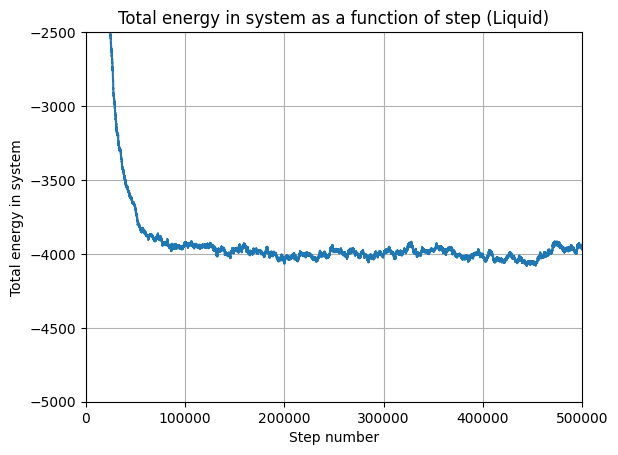

In [ ]:
plt.plot(energy_array_liq)
plt.ylim(-5000,-2500)
plt.xlim(0, 500000)
plt.title("Total energy in system as a function of step (Liquid)")
plt.xlabel("Step number")
plt.ylabel("Total energy in system")
plt.grid()
mean_U_pp = round(np.mean(energy_array_liq[-200000:-1])/N,3)
print(f"{mean_U_pp} average units of energy pr. particle in liquid phase")
print(f"{round(U_full_slicing(x, y, z, L)/N,3)} calculated energy per particle at last coordinate set")
print(np.mean(coord_for_average, axis=0).shape)
""" Trying to make average coordinates work - Can't make it work
xn = coord_for_average[-1][0:-1,0]
yn = coord_for_average[-1][0:-1,1]
zn = coord_for_average[-1][0:-1,2]
xn = np.mean(coord_for_average, axis=0)[0:-1][0:-1,0]
yn = np.mean(coord_for_average, axis=0)[0:-1][0:-1,1]
zn = np.mean(coord_for_average, axis=0)[0:-1][0:-1,2]
print(U_full_slicing(xn,yn,zn,L))
"""

In [ ]:
print(zn.shape)

(998,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Iteration: 0, Energy: 65615018.87, Delta U: 0.00


<ipython-input-77-66949094e4a8>:102: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-delta_U):


Iteration: 1000, Energy: 21073647.22, Delta U: 0.00
Iteration: 2000, Energy: -56.02, Delta U: 0.00
Iteration: 3000, Energy: -127.62, Delta U: 0.00
Iteration: 4000, Energy: -163.44, Delta U: 1.47
Iteration: 5000, Energy: -155.41, Delta U: 0.00
Iteration: 6000, Energy: -162.42, Delta U: 0.00
Iteration: 7000, Energy: -164.46, Delta U: 8268.16
Iteration: 8000, Energy: -175.40, Delta U: 0.00
Iteration: 9000, Energy: -188.39, Delta U: 0.00
Iteration: 10000, Energy: -182.00, Delta U: 1.03
Iteration: 11000, Energy: -184.83, Delta U: 0.32
Iteration: 12000, Energy: -185.43, Delta U: 1.09
Iteration: 13000, Energy: -182.22, Delta U: 0.00
Iteration: 14000, Energy: -185.26, Delta U: 0.00
Iteration: 15000, Energy: -181.92, Delta U: 0.20
Iteration: 16000, Energy: -183.60, Delta U: 0.41
Iteration: 17000, Energy: -195.09, Delta U: -2.53
Iteration: 18000, Energy: -190.55, Delta U: 0.00
Iteration: 19000, Energy: -190.46, Delta U: 0.00
Iteration: 20000, Energy: -194.09, Delta U: 247646.34
Iteration: 21000,

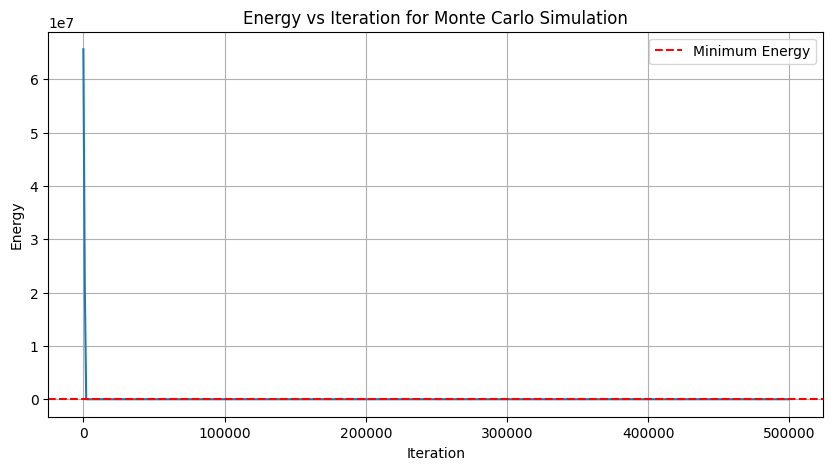

Final energy: -193.87
Minimum energy pr particle -0.225


In [ ]:
# Energy plot - Gas
import numpy as np
import matplotlib.pyplot as plt
# Parameters
N = 1000  # Number of particles
rho = 0.026  # Density liq  = 0.74, Density gas = 0.026
L = (N / rho)**(1/3)  # Length of the cubic box
epsilon = 1.05  # Energy scale based on the condition
sigma = 1.0  # Distance scale
kB = 1.0  # Boltzmann constant
T = 1  # Temperature
num_iterations = 500000  # Can be adjusted with our need
delta = 2  # Maximum displacement for Monte Carlo move Gas

# Initialize particle positions randomly - CHANGED COORDINATESYSTEM to
np.random.seed(0)  # For reproducibility
x = (np.random.rand(N)-0.5) * L # array of N random numbers from -1L to 1L
y = (np.random.rand(N)-0.5) * L
z = (np.random.rand(N)-0.5) * L
print
# Periodic boundary conditions (PBC). If a particle crosses the boundary, it re-enters from the opposite side.
def apply_pbc(dx, dy, dz, L):
    dx = dx - np.round(dx / L) * L
    dy = dy - np.round(dy / L) * L
    dz = dz - np.round(dz / L) * L
    return dx, dy, dz
#Calculate the total potential energy of the system
def U_full_slicing(x, y, z, L):
    result = 0.0
    for d in range(len(x) - 1):
        dx = x[d] - x[d+1:]
        dy = y[d] - y[d+1:]
        dz = z[d] - z[d+1:]
        # Apply periodic boundary conditions (PBC)
        dx, dy, dz = apply_pbc(dx, dy, dz, L)
        # Lennard-Jones potential is used to calculate the interaction energy between particles
        r2 = dx**2 + dy**2 + dz**2
        phi = 4 * epsilon * ((sigma**12 / r2**6) - (sigma**6 / r2**3))
        phi[r2 >= 2.5] = 0  # Safety threshold to ignore large distances
        result += np.sum(phi)
    return result
# Calculating Energy for One Particle, used to compute the energy difference when a particle is moved.
def U_for_one_particle(x, y, z, L, identity):
    # Calculate displacements between particle `identity` and all others
    dx = (x[identity] - x[np.arange(len(x)) != identity])
    dy = (y[identity] - y[np.arange(len(y)) != identity])
    dz = (z[identity] - z[np.arange(len(z)) != identity])

    # Apply PBC
    dx, dy, dz = apply_pbc(dx, dy, dz, L)

    # Calculate distances
    r2 = dx**2 + dy**2 + dz**2
    phi = np.zeros_like(r2)

    # Mask for valid distances under cutoff
    new_mask = r2 < 2.5
    if np.any(r2[new_mask] == 0):
        print("Warning: very close particles detected!")

    # Calculate Lennard-Jones potential
    phi[new_mask] = 4 * 1.05 * ((sigma**12 / r2[new_mask]**6) - (sigma**6 / r2[new_mask]**3))
    return np.sum(phi[new_mask])


# Main simulation loop
U_initial = U_full_slicing(x, y, z, L)
U_last = U_initial

# List to store energy values for plotting
energy_values = []
energy_list = []
energy_array = np.array(energy_list)
energy_interval = 1000  # How often to store energy( just to check)

# Initialize particle position arrays to store coordinates during sampling
sampled_coordinates_gas = []

# Define the number of sampling runs you want after equilibrium
num_samples = 10  # Sample 10000 runs after equilibrium

for iteration in range(num_iterations):
    # Choose a random particle
    identity = np.random.randint(N)
    U_oldp = U_for_one_particle(x, y, z, L, identity)
    # Save the current position
    old_x, old_y, old_z = x[identity], y[identity], z[identity]

    # Propose a new position
    x[identity] += (np.random.rand() - 0.5) * delta
    y[identity] += (np.random.rand() - 0.5) * delta
    z[identity] += (np.random.rand() - 0.5) * delta

    # Apply periodic boundary conditions (PBC)
    x[identity], y[identity], z[identity] = apply_pbc(x[identity], y[identity], z[identity], L)

    # Calculate the energy change
    U_newp = U_for_one_particle(x, y, z, L, identity) # Edited!
    delta_U = U_newp - U_oldp

    # Metropolis acceptance criterion
    if np.random.rand() < np.exp(-delta_U):
        # Accept the move
        U_last += delta_U
    else:
        # Reject the move and revert to the old position
        x[identity], y[identity], z[identity] = old_x, old_y, old_z

    # Updating energy by calculation 10% of the time
    if iteration%(num_iterations/10) == 0:
          U_last = U_full_slicing(x, y, z, L)

    energy_array = np.append(energy_array, U_last) # Appending the previous U to energy array, regardless of acceptance/rejection
    # Calculate and store energy every 1000 iterations
    if iteration % 1000 == 0:
        print(f"Iteration: {iteration}, Energy: {U_last:.2f}, Delta U: {delta_U:.2f}")
 # Store energy every energy_interval iterations
    if iteration % energy_interval == 0:
        energy_values.append(U_last)
    if iteration >= (9*num_iterations/10) and iteration % 100000 == 0 and len(sampled_coordinates_gas) < num_samples:
        # Store current coordinates of all particles
      sampled_coordinates_gas.append(np.vstack((x, y, z)).T)  # Store x, y, z coordinates for all particles
# Plotting the energy values
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_iterations, energy_interval), energy_values)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy vs Iteration for Monte Carlo Simulation')
plt.grid()
plt.axhline(y=np.min(energy_values), color='r', linestyle='--', label='Minimum Energy')
plt.legend()
plt.show()

# Saving the particles' final x, y and z coordinates
x_fin_gas = x
y_fin_gas = y
z_fin_gas= z
energy_array_gas = energy_array

# Final energy output
print(f"Final energy: {U_last:.2f}")
print(f'Minimum energy pr particle {round(min(energy_values)/N,3)}')

-0.195 average units of energy pr. particle in gas phase
-0.194 calculated energy per particle at last coordinate set


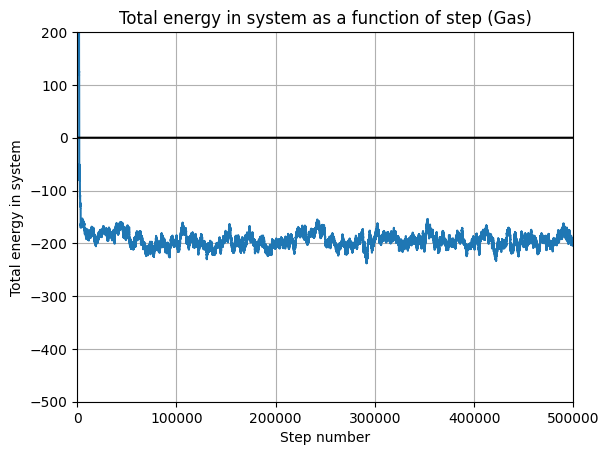

In [ ]:
plt.plot(energy_array_gas)
plt.plot(np.zeros(500000), color="black")
plt.ylim(-500,200)
plt.xlim(0, 500000)
plt.title("Total energy in system as a function of step (Gas)")
plt.xlabel("Step number")
plt.ylabel("Total energy in system")
plt.grid()
mean_U_pp = round(np.mean(energy_array_gas[-200000:-1])/N,3)
print(f"{mean_U_pp} average units of energy pr. particle in gas phase")
print(f"{round(U_full_slicing(x, y, z, L)/N,3)} calculated energy per particle at last coordinate set")

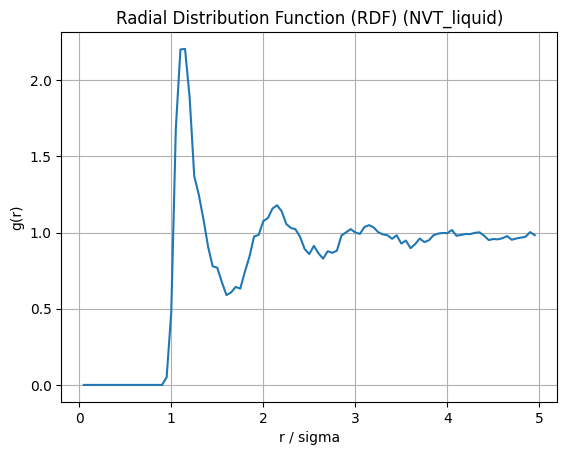

In [ ]:
# Periodic boundary conditions (PBC). If a particle crosses the boundary, it re-enters from the opposite side. - g(r) Liquid
def apply_pbc(dx, dy, dz, L):
    dx = dx - np.round(dx / L) * L
    dy = dy - np.round(dy / L) * L
    dz = dz - np.round(dz / L) * L
    return dx, dy, dz
def g_r(coordinates, L, dr, rho=None,rcutoff=0.9):
    N = len(coordinates)
    # Set max radius to half the smallest box dimension, scaled by rcutoff
    r_max = (L / 2) * rcutoff
    radii = np.arange(dr, r_max, dr)  # radii values for each bin
    n_radii = len(radii)

    # If density (rho) is not provided, calculate it based on the box size
    if rho is None:
        rho = N / (L ** 3)  # number density (N / volume)

    g_r = np.zeros(n_radii)  # Initialize the RDF array

    # Loop over all particle pairs
    for i in range(N):
        for j in range(i + 1, N):
            # Calculate the distance between particles i and j
            dx = coordinates[i, 0] - coordinates[j, 0]
            dy = coordinates[i, 1] - coordinates[j, 1]
            dz = coordinates[i, 2] - coordinates[j, 2]
            # Apply periodic boundary conditions (PBC)
            dx, dy, dz = apply_pbc(dx, dy, dz, L)

            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Find the bin for this distance
            if r < r_max:

                bin_idx = int(r / dr)  # Determine which bin this distance falls into
                # Ensure bin_idx is within the valid range
                if bin_idx < n_radii:
                  g_r[bin_idx] += 2  # Count the pair (both i-j and j-i)
    # Normalize the RDF values
    for bin_idx, r in enumerate(radii):
        shell_vol = (4/3) * np.pi * ((r + dr)**3 - r**3)  # Volume of the spherical shell
        ideal_g_r = rho * shell_vol * N
        if ideal_g_r > 0:
            g_r[bin_idx] /= ideal_g_r  # Normalize g(r) based on the ideal gas distribution


    return g_r, radii

g_r_total_l = np.zeros(len(sampled_coordinates_liq[0]))

dr = 0.05  # Bin width (spacing between radii)
rho_liq = 0.74
L = (N / rho_liq)**(1/3)
n_samples_l = len(sampled_coordinates_liq)
# Loop over all the sampled coordinates and compute g(r)
# Find the smallest g_r length for consistent averaging
min_length = float('inf')

# First, find the minimum length across all g(r) calculations
for coords in sampled_coordinates_liq:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_liq)
    min_length = min(min_length, len(g_r_sample))

# Initialize total g(r) for averaging with the minimum length found
g_r_total_l = np.zeros(min_length)

# Now loop over all the sampled coordinates and compute g(r), truncating to min_length
for coords in sampled_coordinates_liq:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_liq)
    g_r_total_l += g_r_sample[:min_length]  # Truncate to the minimum length

# Average g(r) over the samples
g_r_avg_l = g_r_total_l / n_samples_l

# Truncate radii to match the minimum length
radii_avg_l = radii_sample[:min_length]

# Plot the averaged g(r)
plt.plot(radii_avg_l, g_r_avg_l, label="Averaged g(r)")
plt.xlabel('r / sigma')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) (NVT_liquid)')
plt.grid(True)
plt.show()

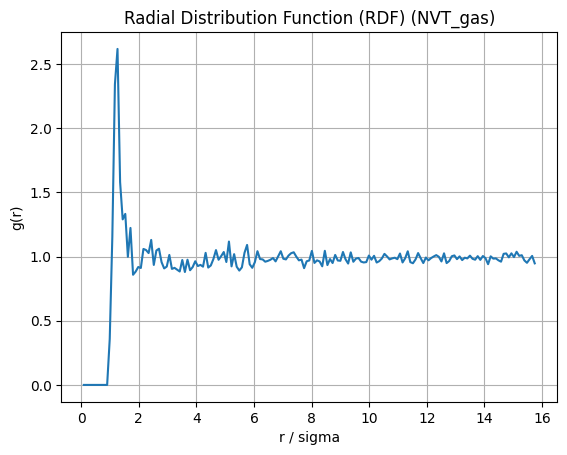

In [ ]:
g_r_total_g = np.zeros(len(sampled_coordinates_gas[0]))
dr = 0.09  # Bin width (spacing between radii)
rho_gas = 0.026
L = (N / rho_gas)**(1/3)
n_samples_g = len(sampled_coordinates_gas)
# Loop over all the sampled coordinates and compute g(r)
# Find the smallest g_r length for consistent averaging
min_length = float('inf')

# First, find the minimum length across all g(r) calculations
for coords in sampled_coordinates_gas:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_gas)
    min_length = min(min_length, len(g_r_sample))

# Initialize total g(r) for averaging with the minimum length found
g_r_total_g = np.zeros(min_length)

# Now loop over all the sampled coordinates and compute g(r), truncating to min_length
for coords in sampled_coordinates_gas:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_gas)
    g_r_total_g += g_r_sample[:min_length]  # Truncate to the minimum length

# Average g(r) over the samples
g_r_avg_g = g_r_total_g / n_samples_g

# Truncate radii to match the minimum length
radii_avg_g = radii_sample[:min_length]

# Plot the averaged g(r)
plt.plot(radii_avg_g, g_r_avg_g, label="Averaged g(r)")
plt.xlabel('r / sigma')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) (NVT_gas)')
plt.grid(True)
plt.show()

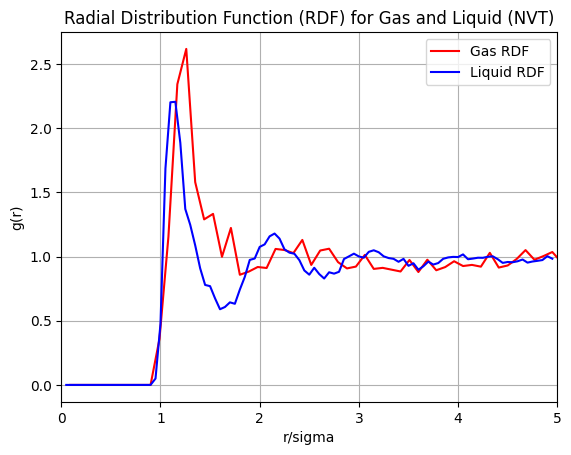

In [ ]:
# Plot the results for gas and liquid RDF on the same plot with different colors
plt.plot(radii_avg_g, g_r_avg_g, label='Gas RDF', color='red')  # Plot gas RDF with blue color
plt.plot(radii_avg_l, g_r_avg_l, label='Liquid RDF', color='blue')  # Plot liquid RDF with red color

# Add labels and title
plt.xlabel('r/sigma')
plt.ylabel('g(r)')
plt.xlim(0,5)
plt.title('Radial Distribution Function (RDF) for Gas and Liquid (NVT)')

# Add a legend to differentiate between gas and liquid
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
u1 = U_full_slicing(x,y,z,L)
u2 = energy_array[-1]
print(np.abs((u1-u2)/u1))

3.307760225140606e-15


In [ ]:
L = (N / rho)**(1/3)
print(U_full_slicing(x, y, z, L)/N)

-3.986889096577996


0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
Min V: 1314.0, Max V = 1355.0
Riemann sum under P(V) = 1.0


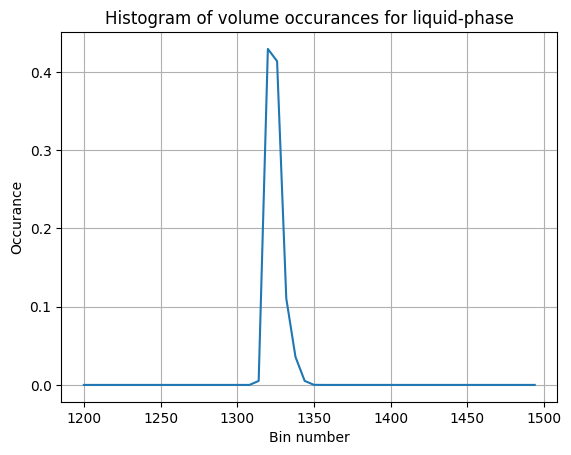

In [ ]:
### P(V) - Liquid
x = x_fin_liq # Importning final x, y and z coordinates from first script
y = y_fin_liq
z = z_fin_liq
### Initial values
N = 1000
bins = 50 # User assigned
num_iterations = 1000000 # User assigned
minV = 1200 # Assumed min and max volumes (important for histogram)
maxV = 1500
T_star = 1/1.05
p = 0.023
rho = 0.74  # Density liq = 0.74, Density gas = 0.026
L = (N / rho)**(1/3)  # Length of the cubic box
V_init = N / rho
dV_max = V_init*0.03 # Liqiud = 3%, Gas = 10%
V_old = V_init
U_attract = 0.0
U_repuls = 0.0
V_array = np.array([])
V_array = np.append(V_array, V_old)
P_V = np.zeros(bins) # Histogram array with length "bins"

### Initial energy calculation for the system divided into attractive and repulsive
def U_system_divided(x, y, z, U_att, U_rep):
  for d in range(len(x) - 1): # Calc. attr. and repul. energies - Uses new-found "optimal" x, y and z vectors from above 10**6 runs initially
    dx = x[d] - x[d+1:]
    dy = y[d] - y[d+1:]
    dz = z[d] - z[d+1:]
    # Apply periodic boundary conditions (PBC)
    dx, dy, dz = apply_pbc(dx, dy, dz, L)
    # Lennard-Jones potential is used to calculate the interaction energy between particles
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    Ua = -4 * 1.05*(1/T_star) * (sigma/ r)**6 # ε = 1.05 but change to 1.05**2?
    Ur = 4 * 1.05*(1/T_star) * (sigma/ r)**12
    U_att += np.sum(Ua)
    U_rep += np.sum(Ur)
  return U_att, U_rep

# Calling function to get initial attractive and repulsive U of system
U_attract, U_repuls = U_system_divided(x, y, z, U_attract, U_repuls)
collected_coordinates_liq = []
### Main simulation loop for volume changes
for iteration in range(num_iterations):
  # Choose a random volume change (positive or negative)
  dV = (np.random.rand() - 0.5) * dV_max
  # Propose a new volume etc.
  V_prop = V_old + dV
  L_prop = V_prop**(1/3)
  # Rescale potential energy for volume change
  Ua_prop = U_attract * (L / L_prop)**6
  Ur_prop = U_repuls * (L / L_prop)**12
  dUa = Ua_prop - U_attract
  dUr = Ur_prop - U_repuls
  # Metropolis acceptance criterion
  if np.random.rand() < np.exp(-(dUa + dUr + p*dV) + N * np.log(V_prop / V_old)):
      # Accept the volume change
      V_old = V_prop
      U_attract = Ua_prop
      U_repuls = Ur_prop
      x = x * (L_prop / L)  # Rescale particle coordinates
      y = y * (L_prop / L)
      z = z * (L_prop / L)
      L = L_prop  # Update the box length

  V_array = np.append(V_array, V_old)  # Volume is sampled (updated and not)
  bin = int(np.floor(((V_old-minV)/(maxV-minV))*bins)) # 1200 is assumed minimum V, 1400-1200 is assumed span of volumes
  bin = min(bin, bins - 1)
  P_V[bin] = P_V[bin] + 1

  # Apply periodic boundary conditions (PBC)
  x, y, z = apply_pbc(x, y, z, L)
  # Recalculate repulsive and attractive energies 10% of the time
  if iteration%(num_iterations/10) == 0:
    U_attract, U_repuls = U_system_divided(x, y, z, U_attract, U_repuls)
  #Collect coordinates during simulation
  if iteration % 100000 == 0:
        current_coordinates = np.vstack((x, y, z)).T  # Combine x, y, z into a single array
        collected_coordinates_liq.append(current_coordinates)  # Store the current coordinates
  # Printing % update
  if iteration % (num_iterations/10) == 0:
      print(f"{round(iteration/num_iterations*100)}% complete")

### Final output graphs and values
print(f"Min V: {np.floor(min(V_array))}, Max V = {np.ceil(max(V_array))}")
P_V = P_V/num_iterations
print(f"Riemann sum under P(V) = {round(sum(P_V),3)}") # Checking that area under graph is 1

# Creating array of bin lables corrosponding to approx. volume (max vol. in each bin) (each bin is a range of volumes)
bin_lab = np.array([])
dW = (maxV-minV)/bins
for i in range(len(P_V)):
  bin_lab = np.append(bin_lab,(minV + i*dW))

plt.plot(bin_lab,P_V) # Plots the histogram on an x-axis coorosponding to volume
plt.title("Histogram of volume occurances for liquid-phase")
plt.xlabel("Bin number")
plt.ylabel("Occurance")
plt.grid()

P_V_l = P_V
bin_lab_l = bin_lab

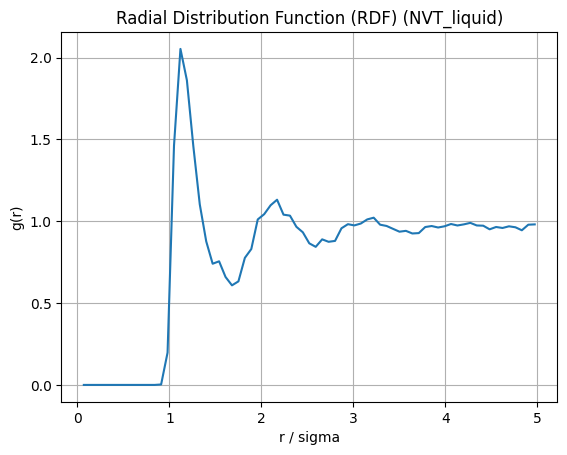

In [ ]:
g_r_total_liq = np.zeros(len(collected_coordinates_liq[0]))

dr = 0.07  # Bin width (spacing between radii)
rho_liq = 0.74
L = (N / rho_liq)**(1/3)
n_samples_liq = len(collected_coordinates_liq)
# Loop over all the sampled coordinates and compute g(r)
# Find the smallest g_r length for consistent averaging
min_length = float('inf')

# First, find the minimum length across all g(r) calculations
for coords in collected_coordinates_liq:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_liq)
    min_length = min(min_length, len(g_r_sample))

# Initialize total g(r) for averaging with the minimum length found
g_r_total_liq = np.zeros(min_length)

# Now loop over all the sampled coordinates and compute g(r), truncating to min_length
for coords in collected_coordinates_liq:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_liq)
    g_r_total_liq += g_r_sample[:min_length]  # Truncate to the minimum length

# Average g(r) over the samples
g_r_avg_liq = g_r_total_liq / n_samples_liq

# Truncate radii to match the minimum length
radii_avg_liq = radii_sample[:min_length]

# Plot the averaged g(r)
plt.plot(radii_avg_liq, g_r_avg_liq, label="Averaged g(r)")
plt.xlabel('r / sigma')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) (NVT_liquid)')
plt.grid(True)
plt.show()

0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
Min V: 38397.0, Max V = 43496.0
Riemann sum under P(V) = 1.0


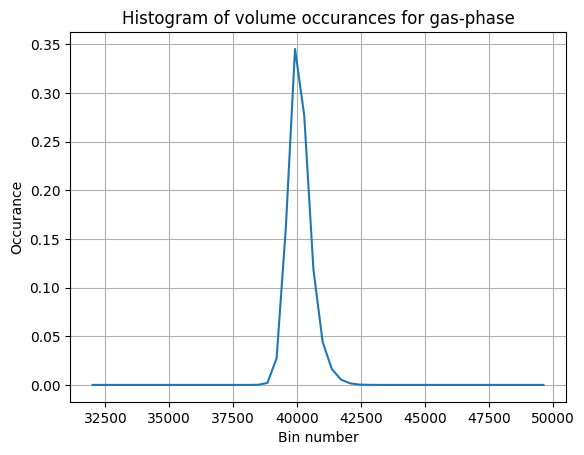

In [ ]:
### P(V) - Gas
x = x_fin_gas # Importning final x, y and z coordinates from first script
y = y_fin_gas
z = z_fin_gas
### Initial values
N = 1000
bins = 50 # User assigned
num_iterations = 1000000 # User assigned
minV = 32000 # Assumed min and max volumes (important for histogram)
maxV = 50000
T_star = 1/1.05 # change beta*epsilon to epsilon/(kb*Tstar)?
p = 0.023
rho = 0.026  # Density liq = 0.74, Density gas = 0.026
L = (N / rho)**(1/3)  # Length of the cubic box
V_init = N / rho
dV_max = V_init*0.10 # Liqiud = 3%, Gas = 10%
V_old = V_init
U_attract = 0.0
U_repuls = 0.0
V_array = np.array([])
V_array = np.append(V_array, V_old)
P_V = np.zeros(bins) # Histogram array with length "bins"

### Initial energy calculation for the system divided into attractive and repulsive
def U_system_divided(x, y, z, U_att, U_rep):
  for d in range(len(x) - 1): # Calc. attr. and repul. energies - Uses new-found "optimal" x, y and z vectors from above 10**6 runs initially
    dx = x[d] - x[d+1:]
    dy = y[d] - y[d+1:]
    dz = z[d] - z[d+1:]
    # Apply periodic boundary conditions (PBC)
    dx, dy, dz = apply_pbc(dx, dy, dz, L)
    # Lennard-Jones potential is used to calculate the interaction energy between particles
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    Ua = -4 * 1.05**2 * (sigma/r)**6 # ε = 1.05 but change to 1.05**2?
    Ur = 4 * 1.05**2 * (sigma/r)**12
    U_att += np.sum(Ua)
    U_rep += np.sum(Ur)
  return U_att, U_rep

# Calling function to get initial attractive and repulsive U of system
U_attract, U_repuls = U_system_divided(x, y, z, U_attract, U_repuls)
collected_coordinates_gas = []
### Main simulation loop for volume changes
for iteration in range(num_iterations):
  # Choose a random volume change (positive or negative)
  dV = (np.random.rand() - 0.5) * dV_max
  # Propose a new volume etc.
  V_prop = V_old + dV
  L_prop = V_prop**(1/3)
  # Rescale potential energy for volume change
  Ua_prop = U_attract * (L / L_prop)**6
  Ur_prop = U_repuls * (L / L_prop)**12
  dUa = Ua_prop - U_attract
  dUr = Ur_prop - U_repuls
  # Metropolis acceptance criterion
  if np.random.rand() < np.exp(-(dUa + dUr + p*dV) + N * np.log(V_prop / V_old)):
      # Accept the volume change
      V_old = V_prop
      U_attract = Ua_prop
      U_repuls = Ur_prop
      x = x * (L_prop / L)  # Rescale particle coordinates
      y = y * (L_prop / L)
      z = z * (L_prop / L)
      L = L_prop  # Update the box length

  V_array = np.append(V_array, V_old)  # Volume is sampled (updated and not)
  bin = int(np.floor(((V_old-minV)/(maxV-minV))*bins)) # 1200 is assumed minimum V, 1400-1200 is assumed span of volumes
  P_V[bin] = P_V[bin] + 1

  # Apply periodic boundary conditions (PBC)
  x, y, z = apply_pbc(x, y, z, L)
  # Recalculate repulsive and attractive energies 10% of the time
  if iteration%(num_iterations/10) == 0:
    U_attract, U_repuls = U_system_divided(x, y, z, U_attract, U_repuls)
  #Collect coordinates during simulation
  if iteration % 100000 == 0:
        current_coordinates = np.vstack((x, y, z)).T  # Combine x, y, z into a single array
        collected_coordinates_gas.append(current_coordinates)  # Store the current coordinates
  # Printing % update
  if iteration % (num_iterations/10) == 0:
      print(f"{round(iteration/num_iterations*100)}% complete")

### Final output graphs and values
print(f"Min V: {np.floor(min(V_array))}, Max V = {np.ceil(max(V_array))}")
P_V = P_V/num_iterations
print(f"Riemann sum under P(V) = {round(sum(P_V),3)}") # Checking that area under graph is 1

# Creating array of bin lables corrosponding to approx. volume (max vol. in each bin) (each bin is a range of volumes)
bin_lab = np.array([])
dW = (maxV-minV)/bins
for i in range(len(P_V)):
  bin_lab = np.append(bin_lab,(minV + i*dW))

plt.plot(bin_lab,P_V) # Plots the histogram on an x-axis coorosponding to volume
plt.title("Histogram of volume occurances for gas-phase")
plt.xlabel("Bin number")
plt.ylabel("Occurance")
plt.grid()

P_V_g = P_V
bin_lab_g = bin_lab

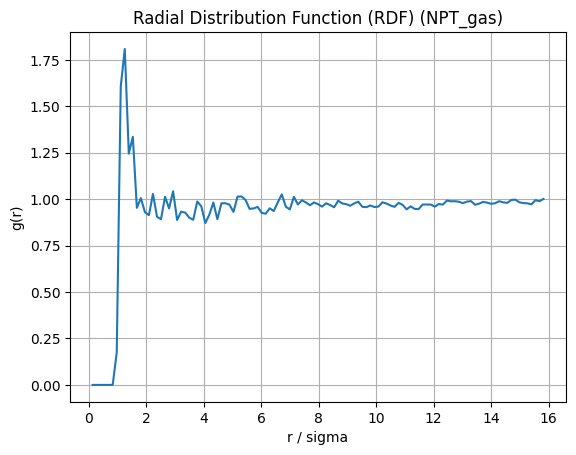

In [ ]:
g_r_total_gas = np.zeros(len(collected_coordinates_gas[0]))
dr = 0.14  # Bin width (spacing between radii)
rho_gas = 0.026
L = (N / rho_gas)**(1/3)
n_samples_gas = len(collected_coordinates_gas)
# Loop over all the sampled coordinates and compute g(r)
# Find the smallest g_r length for consistent averaging
min_length = float('inf')

# First, find the minimum length across all g(r) calculations
for coords in collected_coordinates_gas:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_gas)
    min_length = min(min_length, len(g_r_sample))

# Initialize total g(r) for averaging with the minimum length found
g_r_total_gas = np.zeros(min_length)

# Now loop over all the sampled coordinates and compute g(r), truncating to min_length
for coords in collected_coordinates_gas:
    g_r_sample, radii_sample = g_r(coords, L, dr, rho=rho_gas)
    g_r_total_gas += g_r_sample[:min_length]  # Truncate to the minimum length

# Average g(r) over the samples
g_r_avg_gas = g_r_total_gas / n_samples_gas

# Truncate radii to match the minimum length
radii_avg_gas = radii_sample[:min_length]

# Plot the averaged g(r)
plt.plot(radii_avg_gas, g_r_avg_gas, label="Averaged g(r)")
plt.xlabel('r / sigma')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) (NPT_gas)')
plt.grid(True)
plt.show()

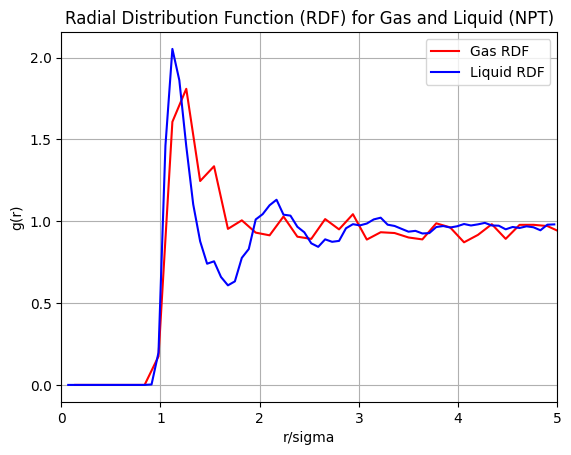

In [ ]:
# Plot the results for gas and liquid RDF on the same plot with different colors
plt.plot(radii_avg_gas, g_r_avg_gas, label='Gas RDF', color='red')  # Plot gas RDF with blue color
plt.plot(radii_avg_liq, g_r_avg_liq, label='Liquid RDF', color='blue')  # Plot liquid RDF with red color

# Add labels and title
plt.xlabel('r/sigma')
plt.ylabel('g(r)')
plt.xlim(0,5)
plt.title('Radial Distribution Function (RDF) for Gas and Liquid (NPT)')

# Add a legend to differentiate between gas and liquid
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
#Saving N=1000 P(V) results
P_V_G_1000
V_array_g_1000
bin_lab_g_1000
#np.savetxt("V_array_gas_1000",V_array_g_1000, delimiter=",")

In [ ]:
#Saving N=100 P(V) results
P_V_G_100
V_array_g_100
bin_lab_g_100
#np.savetxt("V_array_gas_100",V_array_g_100, delimiter=",")

In [ ]:
#Saving N=10 P(V) results
P_V_G_10
V_array_g_10
bin_lab_g_10
#np.savetxt("V_array_gas_10",V_array_g_10, delimiter=",")

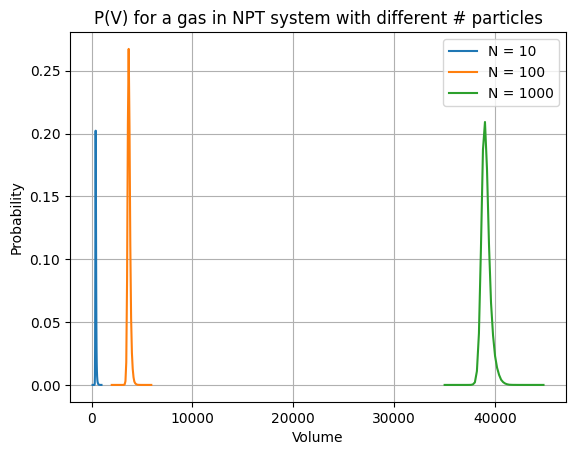

In [ ]:
plt.plot(bin_lab_g_10,P_V_G_10,label="N = 10")
plt.plot(bin_lab_g_100,P_V_G_100, label="N = 100")
plt.plot(bin_lab_g_1000,P_V_G_1000,label="N = 1000")
plt.legend()
plt.title("P(V) for a gas in NPT system with different # particles")
plt.xlabel("Volume")
plt.ylabel("Probability")
plt.grid()
plt.show()

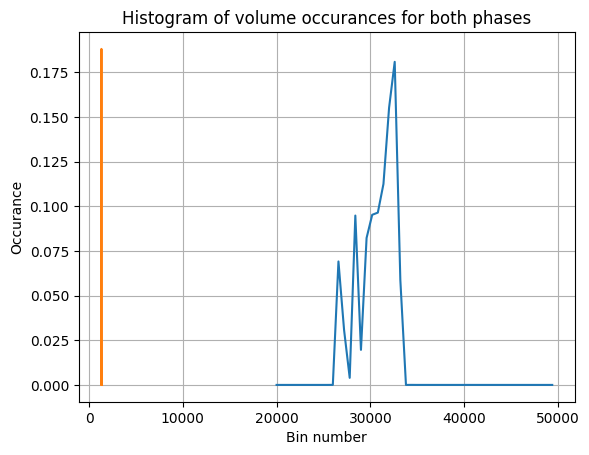

In [ ]:
plt.plot(bin_lab_g,P_V_g) # Plots the histogram on an x-axis coorosponding to volume
plt.plot(bin_lab_l,P_V_l) # Plots the histogram on an x-axis coorosponding to volume
plt.title("Histogram of volume occurances for both phases")
plt.xlabel("Bin number")
plt.ylabel("Occurance")
plt.grid()
plt.show()

In [ ]:
# 1. Calculate the corresponding density for each volume change
density_array = N / V_array  # Density at each iteration

# 2. Calculate <1/V> and 1/<V>
inv_V_avg = np.mean(1 / V_array)


# 3. Plot the density distribution
plt.figure(figsize=(10, 5))
plt.hist(density_array, bins=30, density=True, alpha=0.7, color='b', label='Density Distribution')
plt.axvline(np.mean(density_array), color='r', linestyle='--', label=r'$\langle \rho \rangle$')
plt.xlabel('Density')
plt.ylabel('Probability Density')
plt.title('Density Distribution for NPT Simulation')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'N' is not defined

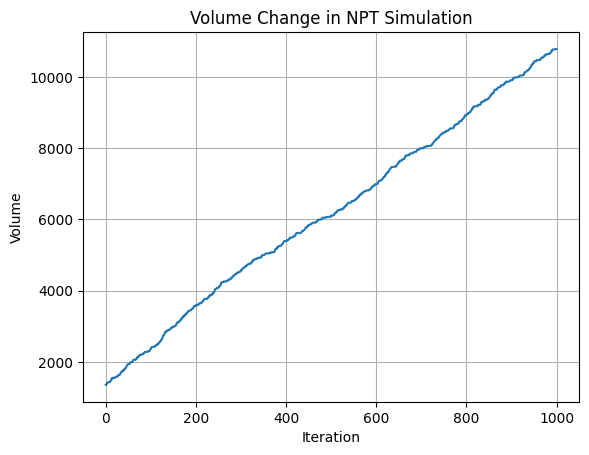

In [ ]:
# Plotting the volume changes over iterations
plt.plot(range(num_iterations + 1), V_array)
plt.xlabel('Iteration')
plt.ylabel('Volume')
plt.title('Volume Change in NPT Simulation')
plt.grid(True)
plt.show()

In [ ]:
# Function to calculate the radial distribution function g(r) (still weird in NPT)
def radial_distribution_function(x, y, z, L, bins=100, r_max=None, num_samples=1):
    N = len(x)  # Number of particles
    r_max = L / 2  # Use half the box length as max distance

    distances = []

    # Calculate distances between all particle pairs
    for i in range(N):
        for j in range(i + 1, N):
            dx = x[i] - x[j]
            dy = y[i] - y[j]
            dz = z[i] - z[j]
            dx, dy, dz = apply_pbc(dx, dy, dz, L)
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            if r < r_max:
                distances.append(r)

    distances = np.array(distances)

    # Create a histogram of distances
    hist, bin_edges = np.histogram(distances, bins=bins, range=(0, r_max), density=True)

    # Calculate the midpoints of the bins
    r_values = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Calculate the volume of each spherical shell
    shell_volumes = 4.0 / 3.0 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

    # Number density of the system
    rho = N / L**3
    # Calculate local density n(r) for each bin
    n_r = hist / shell_volumes
    # Compute g(r) based on your provided formula
    g_r = hist / (num_samples * N * shell_volumes * rho)
    # Calculate g(r) = n(r) / <n>
    #g_r = n_r / rho

    return r_values, g_r

# Example setup with sampled configurations
# Assuming x, y, z are the particle coordinates for a specific snapshot
r_values, g_r = radial_distribution_function(x, y, z, L, bins=100, num_samples=num_iterations)

# Plotting g(r)
plt.figure(figsize=(10, 5))
plt.plot(r_values, g_r)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function g(r)')
plt.grid(True)
plt.show()

NameError: name 'x' is not defined

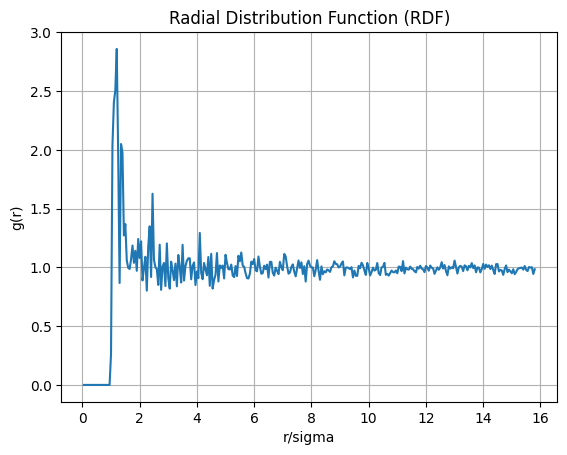

In [ ]:
# Periodic boundary conditions (PBC). If a particle crosses the boundary, it re-enters from the opposite side. p(r) Gas
def apply_pbc(dx, dy, dz, L):
    dx = dx - np.round(dx / L) * L
    dy = dy - np.round(dy / L) * L
    dz = dz - np.round(dz / L) * L
    return dx, dy, dz

def g_r(coordinates, L, dr, rho=None, rcutoff=0.9):
    N = len(coordinates)
    # Set max radius to half the smallest box dimension, scaled by rcutoff
    r_max = (L / 2) * rcutoff
    radii = np.arange(dr, r_max, dr)  # radii values for each bin
    n_radii = len(radii)

    # If density (rho) is not provided, calculate it based on the box size
    if rho is None:
        rho = N / (L ** 3)  # number density (N / volume)

    g_r = np.zeros(n_radii)  # Initialize the RDF array

    # Loop over all particle pairs
    for i in range(N):
        for j in range(i + 1, N):
            # Calculate the distance between particles i and j
            dx = coordinates[i, 0] - coordinates[j, 0]
            dy = coordinates[i, 1] - coordinates[j, 1]
            dz = coordinates[i, 2] - coordinates[j, 2]
            # Apply periodic boundary conditions (PBC)
            dx, dy, dz = apply_pbc(dx, dy, dz, L)

            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Find the bin for this distance
            if r < r_max:

                bin_idx = int(r / dr)  # Determine which bin this distance falls into
                # Ensure bin_idx is within the valid range
                if bin_idx < n_radii:
                  g_r[bin_idx] += 2  # Count the pair (both i-j and j-i)
    # Normalize the RDF values
    for bin_idx, r in enumerate(radii):
        shell_vol = (4/3) * np.pi * ((r + dr)**3 - r**3)  # Volume of the spherical shell
        ideal_g_r = rho * shell_vol * N
        if ideal_g_r > 0:
            g_r[bin_idx] /= ideal_g_r  # Normalize g(r) based on the ideal gas distribution


    return g_r, radii
coords = sampled_coordinates_gas[-1]

dr = 0.05  # Bin width (spacing between radii)
rho_gas = 0.026
L = (N / rho_gas)**(1/3)
g_r, radii = g_r(coords, L, dr)
# Rescale r to r/sigma for Lennard-Jones systems
r_scaled = radii / sigma
# Plot the results
plt.plot(radii, g_r)
plt.xlabel('r/sigma')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF)')
plt.grid(True)
plt.show()

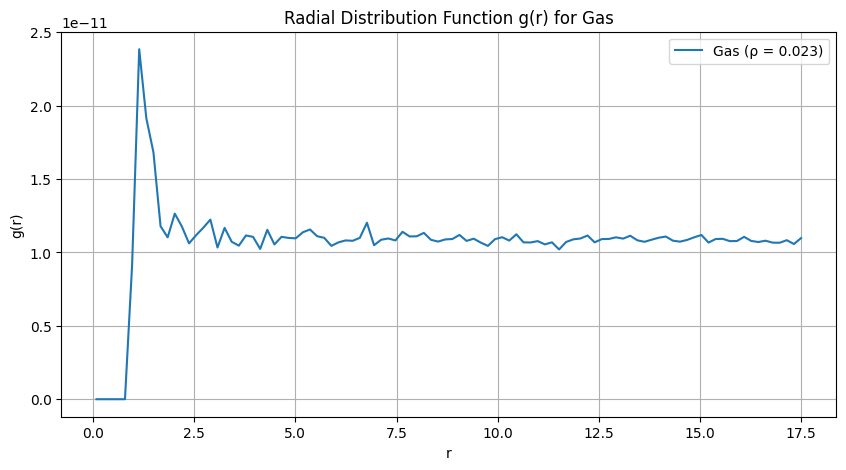

In [ ]:
# Xin's g(r) Gas
import numpy as np
import matplotlib.pyplot as plt

# Function to apply periodic boundary conditions (PBC)
def apply_pbc(dx, dy, dz, L):
    dx = dx - np.round(dx / L) * L
    dy = dy - np.round(dy / L) * L
    dz = dz - np.round(dz / L) * L
    return dx, dy, dz

# Radial distribution function calculation
def radial_distribution_function(x, y, z, L, bins=100, num_samples=1):
    N = len(x)  # Number of particles
    r_max = L / 2  # Use half the box length as max distance

    distances = []

    # Calculate distances between all particle pairs
    for i in range(N):
        for j in range(i + 1, N):
            dx = x[i] - x[j]
            dy = y[i] - y[j]
            dz = z[i] - z[j]
            dx, dy, dz = apply_pbc(dx, dy, dz, L)
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            if r < r_max:
                distances.append(r)

    distances = np.array(distances)

    # Create a histogram of distances
    hist, bin_edges = np.histogram(distances, bins=bins, range=(0, r_max), density=True)

    # Calculate the midpoints of the bins
    r_values = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Calculate the volume of each spherical shell
    shell_volumes = 4.0 / 3.0 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

    # Number density of the system
    rho = N / L**3

    # Compute g(r)
    g_r = hist / (num_samples * N * shell_volumes * rho)

    return r_values, g_r

# Parameters for gas phase
N = 1000  # Number of particles
num_iterations = 1000000  # Number of iterations
delta = 0.1  # Maximum displacement for Monte Carlo move


# Gas phase
rho_gas = 0.026
L_gas = (N / rho_gas)**(1/3)  # Box length for gas
np.random.seed(1)
x_gas = (np.random.rand(N) - 0.5) * L_gas
y_gas = (np.random.rand(N) - 0.5) * L_gas
z_gas = (np.random.rand(N) - 0.5) * L_gas


# Calculate g(r) for gas phase
# r_values_gas, g_r_gas = radial_distribution_function(x_gas, y_gas, z_gas, L_gas, bins=100, num_samples=num_iterations)
r_values_gas, g_r_gas = radial_distribution_function(x_fin_gas, y_fin_gas, z_fin_gas, L_gas, bins=100, num_samples=num_iterations)

# Plotting g(r) for gas
plt.figure(figsize=(10, 5))
plt.plot(r_values_gas, g_r_gas, label='Gas (ρ = 0.026)')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function g(r) for Gas')
plt.legend()
plt.grid(True)
plt.show()

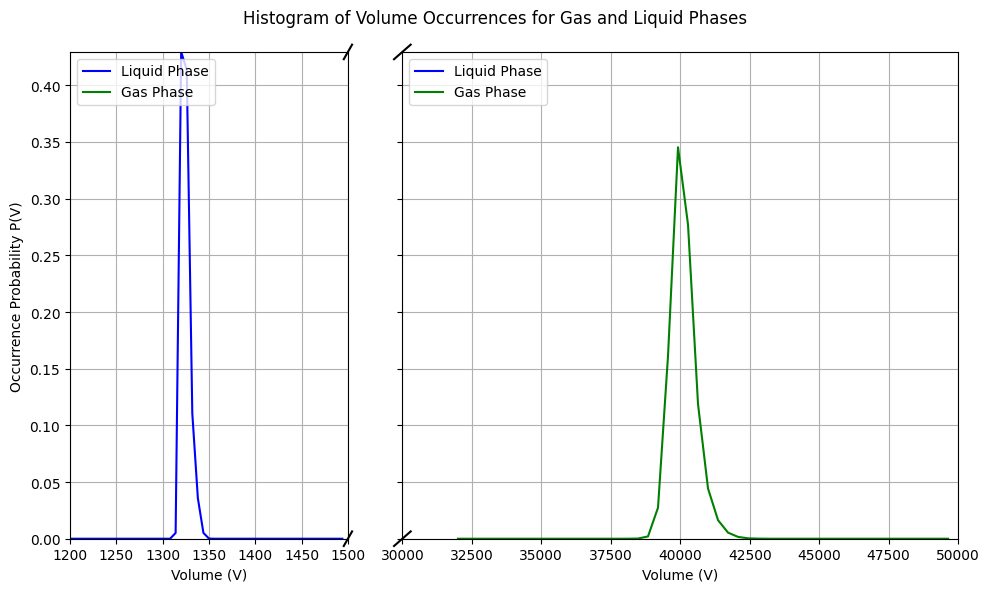

In [ ]:
from matplotlib import gridspec
# Create a figure and two subplots (split the x-axis into two parts)
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # Two grids with different widths

# Left subplot for range 1000-2000
ax1 = plt.subplot(gs[0])
# Right subplot for range 35000-50000
ax2 = plt.subplot(gs[1])

# Plot the liquid phase on both axes
ax1.plot(bin_lab_l, P_V_l, label="Liquid Phase", color="blue")
ax2.plot(bin_lab_l, P_V_l, label="Liquid Phase", color="blue")

# Plot the gas phase on both axes
ax1.plot(bin_lab_g, P_V_g, label="Gas Phase", color="green")
ax2.plot(bin_lab_g, P_V_g, label="Gas Phase", color="green")

# Set limits for the x-axis for both subplots
ax1.set_xlim(1200, 1500)  # Left axis
ax2.set_xlim(30000, 50000)  # Right axis

# Set the same y-axis limits for both subplots
ax1.set_ylim(0, max(max(P_V_l), max(P_V_g)))
ax2.set_ylim(0, max(max(P_V_l), max(P_V_g)))

# Add labels and title
ax1.set_xlabel("Volume (V)")
ax1.set_ylabel("Occurrence Probability P(V)")
ax2.set_xlabel("Volume (V)")
ax2.set_yticklabels([])  # Hide y-axis labels on the right

# Add legend to both subplots
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")

# Add grid
ax1.grid(True)
ax2.grid(True)

# Add breaks in the axes
d = 0.015  # Size of the diagonal lines indicating the break

# Draw the diagonal lines for the left plot (upper right and lower right)
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Draw the diagonal lines for the right plot (upper left and lower left)
kwargs.update(transform=ax2.transAxes)  # Apply the same to the right plot
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.suptitle("Histogram of Volume Occurrences for Gas and Liquid Phases")

# Show the plot
plt.tight_layout()
plt.show()

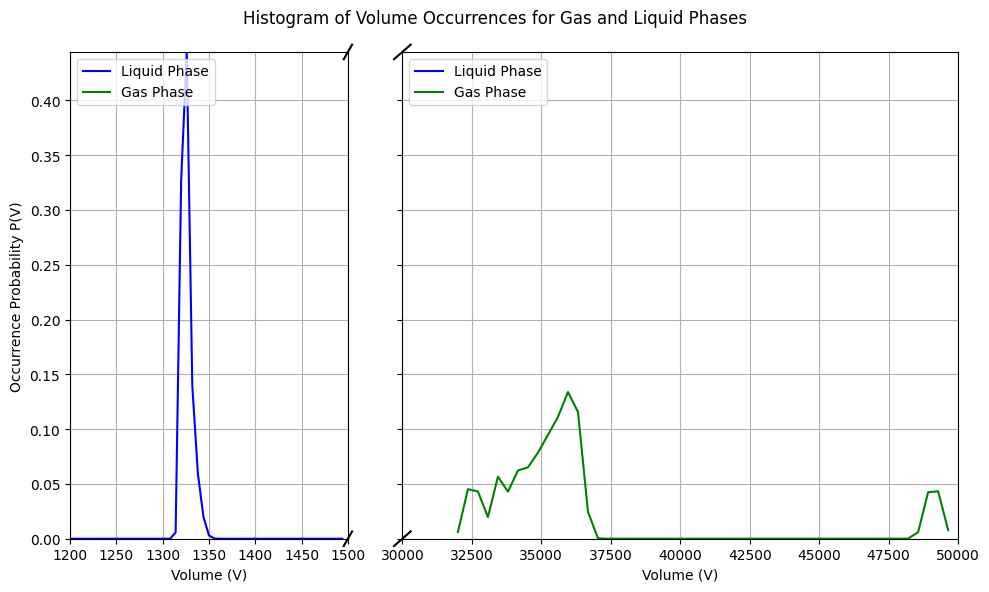

In [ ]:
from matplotlib import gridspec
# Create a figure and two subplots (split the x-axis into two parts)
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # Two grids with different widths

# Left subplot for range 1000-2000
ax1 = plt.subplot(gs[0])
# Right subplot for range 35000-50000
ax2 = plt.subplot(gs[1])

# Plot the liquid phase on both axes
ax1.plot(bin_lab_l, P_V_l, label="Liquid Phase", color="blue")
ax2.plot(bin_lab_l, P_V_l, label="Liquid Phase", color="blue")

# Plot the gas phase on both axes
ax1.plot(bin_lab_g, P_V_g, label="Gas Phase", color="green")
ax2.plot(bin_lab_g, P_V_g, label="Gas Phase", color="green")

# Set limits for the x-axis for both subplots
ax1.set_xlim(1200, 1500)  # Left axis
ax2.set_xlim(30000, 50000)  # Right axis

# Set the same y-axis limits for both subplots
ax1.set_ylim(0, max(max(P_V_l), max(P_V_g)))
ax2.set_ylim(0, max(max(P_V_l), max(P_V_g)))

# Add labels and title
ax1.set_xlabel("Volume (V)")
ax1.set_ylabel("Occurrence Probability P(V)")
ax2.set_xlabel("Volume (V)")
ax2.set_yticklabels([])  # Hide y-axis labels on the right

# Add legend to both subplots
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")

# Add grid
ax1.grid(True)
ax2.grid(True)

# Add breaks in the axes
d = 0.015  # Size of the diagonal lines indicating the break

# Draw the diagonal lines for the left plot (upper right and lower right)
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Draw the diagonal lines for the right plot (upper left and lower left)
kwargs.update(transform=ax2.transAxes)  # Apply the same to the right plot
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.suptitle("Histogram of Volume Occurrences for Gas and Liquid Phases")

# Show the plot
plt.tight_layout()
plt.show()

Average Volume: 430.31
Average Volume: 3751.20
Average Volume: 39198.37
Average Density: 0.0232
Average Density: 0.0267
Average Density: 0.0255


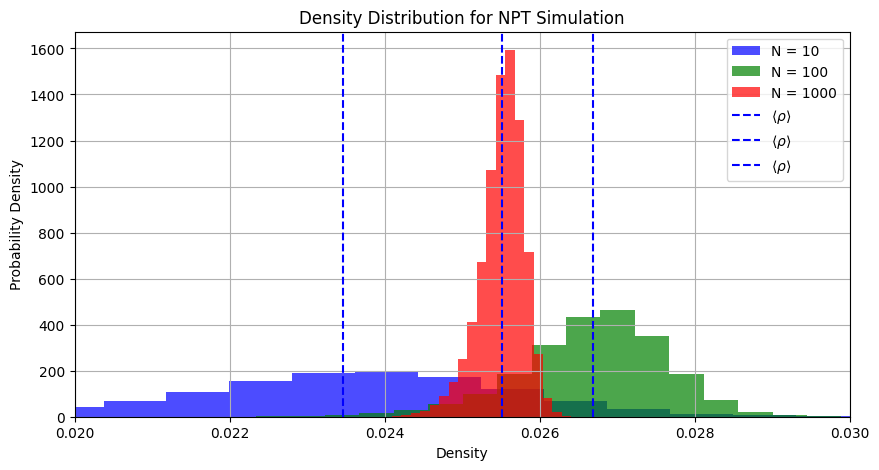

In [ ]:
# Calculate the average volume_gas
average_volume_g_10 = np.mean(V_array_g_10)
average_volume_g_100 = np.mean(V_array_g_100)
average_volume_g_1000 = np.mean(V_array_g_1000)

# Print the average volume
print(f"Average Volume: {average_volume_g_10:.2f}")
print(f"Average Volume: {average_volume_g_100:.2f}")
print(f"Average Volume: {average_volume_g_1000:.2f}")

N_10 = 10
N_100 = 100
N_1000 = 1000
# Calculate the average density
average_density_g_10 = N_10 / average_volume_g_10
average_density_g_100 = N_100 / average_volume_g_100
average_density_g_1000 = N_1000 / average_volume_g_1000

# Print the average density
print(f"Average Density: {average_density_g_10:.4f}")
print(f"Average Density: {average_density_g_100:.4f}")
print(f"Average Density: {average_density_g_1000:.4f}")
# Inverse of volume to get density at each step
density_array_g_10 = N_10 / V_array_g_10  # Density at each iteration
density_array_g_100 = N_100 / V_array_g_100  # Density at each iteration
density_array_g_1000 = N_1000 / V_array_g_1000  # Density at each iteration
# Plot the density distribution
plt.figure(figsize=(10, 5))
plt.hist(density_array_g_10, bins=30, density=True, alpha=0.7, color='b', label='N = 10')
plt.hist(density_array_g_100, bins=30, density=True, alpha=0.7, color='g', label='N = 100')
plt.hist(density_array_g_1000, bins=30, density=True, alpha=0.7, color='r', label='N = 1000')
plt.axvline(np.mean(density_array_g_10), color='b', linestyle='--', label=r'$\langle \rho \rangle$')
plt.axvline(np.mean(density_array_g_100), color='b', linestyle='--', label=r'$\langle \rho \rangle$')
plt.axvline(np.mean(density_array_g_1000), color='b', linestyle='--', label=r'$\langle \rho \rangle$')

plt.xlabel('Density')
plt.ylabel('Probability Density')
plt.title('Density Distribution for NPT Simulation')
plt.xlim(0.02,0.03)
plt.legend()
plt.grid(True)
plt.show()